<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/DP_BBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!git clone https://github.com/knamdar/data.git

fatal: destination path 'Bayesian-Neural-Networks' already exists and is not an empty directory.
fatal: destination path 'data' already exists and is not an empty directory.


# Base Network Wrapper

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaseNet(object):
    def __init__(self):
        print('\nNet:')

    def get_nb_parameters(self):
        return sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def save(self, filename):
        print('Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        print('Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.model


class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b).sum()
        else:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b)

class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
        self.cte_term = -(0.5)*np.log(2*np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):
        
        dist_term = -(0.5)*((x - self.mu)/self.sigma)**2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)
    

# TODO: adapt so can be done without sum
class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)
        
        self.pi1 = pi 
        self.pi2 = (1-pi)

    def loglike(self, x):
        
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)
        
        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 + torch.exp(N1_ll - max_loglike) + self.pi2 + torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike
    
        return loglike


In [ ]:
def isnan(tensor):
  # Gross: https://github.com/pytorch/pytorch/issues/4767
    return (tensor != tensor)

def hasnan(tensor):
    return isnan(tensor).any()

def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    
    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum() # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
#     print(hasnan(x.data), hasnan(mu.data), hasnan(sigma.data), out)
#     if isnan(out) or hasnan(out):
#         print('NAaaanNNN')
#         print('mu max', mu.max())
#         print('mu min', mu.min())
#         print('sigma max', sigma.max())
#         print('sigma min', sigma.min())
#         print('x max', x.max())
#         print('x min', x.min())
#         print((x - mu).max())
#         print((x - mu).min())
#         print(hasnan(inner))
#         print(dist_term)
#         print(hasnan(dist_term))
    return out 



class BayesLinear_Normalq(nn.Module):
    def __init__(self, n_in, n_out, prior_class):
        super(BayesLinear_Normalq, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior = prior_class
        
        # Learnable parameters
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.2, 0.2))
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-3, -2))
        
        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.2, 0.2))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-3, -2))
        
       
        self.lpw = 0
        self.lqw = 0
        
                                   
    def forward(self, X, sample=False):
#         print(self.training)

        if not self.training and not sample: # This is just a placeholder function
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0
                                       
        else:
                              
            # Tensor.new()  Constructs a new tensor of the same data type as self tensor. 
            # the same random sample is used for every element in the minibatch
            eps_W = Variable(self.W_mu.data.new(self.W_mu.size()).normal_())
            eps_b = Variable(self.b_mu.data.new(self.b_mu.size()).normal_())
                                       
            # sample parameters         
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)                      
                                   
            W = self.W_mu + 1 * std_w * eps_W
            b = self.b_mu + 1 * std_b * eps_b          
    
            
            output = torch.mm(X, W) + b.unsqueeze(0).expand(X.shape[0], -1) # (batch_size, n_output)
            
            lqw = isotropic_gauss_loglike(W, self.W_mu, std_w) + isotropic_gauss_loglike(b, self.b_mu, std_b)
            lpw = self.prior.loglike(W) + self.prior.loglike(b)
            return output, lqw, lpw

In [ ]:
def sample_weights(W_mu, b_mu, W_p, b_p):
    
    eps_W = W_mu.data.new(W_mu.size()).normal_()
    # sample parameters         
    std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)     
    W = W_mu + 1 * std_w * eps_W
    
    if b_mu is not None:
        std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)  
        eps_b = b_mu.data.new(b_mu.size()).normal_()
        b = b_mu + 1 * std_b * eps_b
    else:
        b = None
    
    return W, b

# DPBBP: define the Bayes linear 2l with Gaussian prior 

In [ ]:
class bayes_linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(bayes_linear_2L, self).__init__()
        
        n_hid = 1200
#         prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
#         prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
        self.prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        
        tlqw = 0
        tlpw = 0
        
        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        return y, tlqw, tlpw
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)
        
        for i in range(Nsamples):
            
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw 
            
        return predictions, tlqw_vec, tlpw_vec

# DPBBP training MNIST (Gaussian)

In [ ]:
import copy

class Bayes_Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, Nbatches=0):
        super(Bayes_Net, self).__init__()
        print(' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0,weight_decay =0.0)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = x.to(device), y.long().to(device)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='none')
            Edkl = (tlqw - tlpw)/self.Nbatches
            
        elif samples > 1:
            mlpdw_cum = torch.zeros_like(y)
            Edkl_cum = 0
            
            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='none')
                Edkl_i = (tlqw - tlpw)/self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i 
            
            mlpdw = mlpdw_cum/samples
            Edkl = Edkl_cum/samples
  
        loss = Edkl+mlpdw

        #########################################################################################################
        clipped_grads = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

        for i in range(loss.size(0)):
            loss[i].backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.5)
            for name, param in self.model.named_parameters():
                clipped_grads[name] += param.grad / loss.size(0)
            self.model.zero_grad()

        for name, param in self.model.named_parameters():
            param.grad = clipped_grads[name]

        self.optimizer.step()
        with torch.no_grad():
            for param in self.model.parameters():
                param.add_(torch.randn_like(param) * 1.3/loss.size(0))
        #########################################################################################################

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, torch.mean(mlpdw.data), err

    def eval(self, x, y, train=False):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')
        print(out)
        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []
        
        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name+'.W_mu'].data
                    W_p = state_dict[layer_name+'.W_p'].data

    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)
    
    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu)/sig_W)
                b_snr = (torch.abs(b_mu)/sig_b)
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = W_snr > thresh
                    mask_dict[layer_name+'.b'] = b_snr > thresh
                    
                else:
                
                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)
        
        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)
    
    
    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                
                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)  
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)  
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w, do_sum=False) - self.model.prior_instance.loglike(W, do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b, do_sum=False) - self.model.prior_instance.loglike(b, do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = KL_W > thresh
                    mask_dict[layer_name+'.b'] = KL_b > thresh
                    
                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)
        
        if thresh is not None:
            return mask_dict
        else:    
            return np.array(weight_KLD_vec)

In [ ]:
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy

# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 100
nb_epochs = 15
log_interval = 1

savemodel_its = [20, 50, 80, 120]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
print('\nData:')


# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
print( '\nNetwork:')

lr = 0.25
nsamples = 3
########################################################################################
net = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))


Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/15, Jtr_KL = 119.519683, Jtr_pred = 1.079220, err = 0.554533,    time: 464.800558 seconds

    Jdev = 99.044337, err = 0.346900

best test error
Writting ../theta_best.dat

it 1/15, Jtr_KL = 262.647483, Jtr_pred = 2.169180, err = 0.414000,    time: 466.484355 seconds

    Jdev = 173.353150, err = 0.310500

best test error
Writting ../theta_best.dat

it 2/15, Jtr_KL = 374.145467, Jtr_pred = 3.202413, err = 0.391900,    time: 467.983342 seconds

    Jdev = 224.136250, err = 0.275700

best test error
Writting ../theta_best.dat

it 3/15, Jtr_KL = 460.793067, Jtr_pred = 3.768273, err = 0.345183,    time: 468.936802 seconds

    Jdev = 281.046525, err = 0.262300

best test error
Writting ../theta_best.dat

it 4/15, Jtr_KL = 531.474033, Jtr_pred = 4.644917, err = 0.349950,    time: 467.651583 seconds

    Jdev = 291.735725, err = 0.250600

best test error
Writting ../theta_best.dat

it 5/15, Jt

<Figure size 600x400 with 0 Axes>

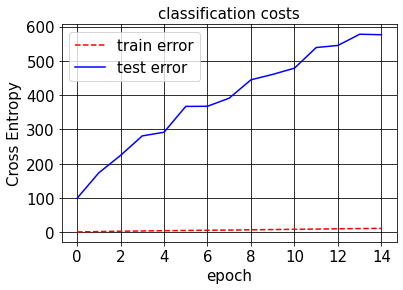

<Figure size 432x288 with 0 Axes>

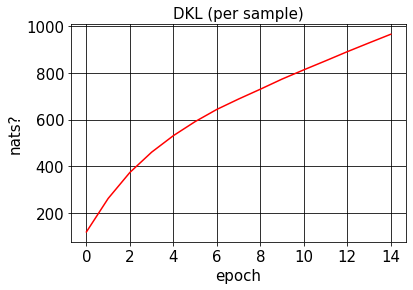

<Figure size 600x400 with 0 Axes>

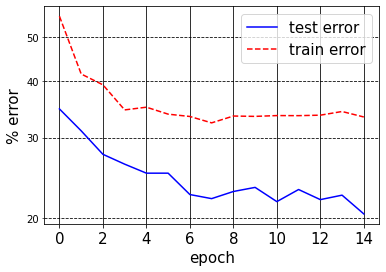

In [ ]:
## ---------------------------------------------------------------------------------------------------------------------
# train
print('\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=nsamples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    print('   time: %f seconds\n' % (toc - tic))

    # Save state dict
    
    if i in savemodel_its:
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        print('    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            print('best test error')
            net.save('../theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
print( '   average time: %f seconds\n' % runtime_per_it)

net.save('../theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
print( '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
#print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save('../cost_train.npy', kl_cost_train)
np.save('../cost_train.npy', pred_cost_train)
np.save('../cost_dev.npy', cost_dev)
np.save('../err_train.npy', err_train)
np.save('../err_dev.npy', err_dev)



In [ ]:
model_local = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))
model_local.load('/content/theta_best.dat')


Net:
 Creating Net!! 
    Total params: 4.79M
Reading /content/theta_best.dat

  restoring epoch: 14, lr: 0.250000


bayes_linear_2L(
  (bfc1): BayesLinear_Normalq()
  (bfc2): BayesLinear_Normalq()
  (bfc3): BayesLinear_Normalq()
  (act): ReLU(inplace=True)
)

In [ ]:
#model_local.to(device)
#model_local.eval()
from tqdm import tqdm
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob =  model_local.eval(data,target)
            #acc += err
            #print(np.array(prob.cpu().detach().numpy())[0])
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)


  4%|▍         | 4/100 [00:00<00:16,  5.85it/s]

tensor([[ 3.9004e+03,  1.7169e+03,  4.1699e+02,  1.5040e+03, -1.3314e+03,
         -8.0635e+02, -4.1151e+03,  1.2721e+04, -3.1561e+03,  3.5485e+03],
        [ 5.7599e+03,  5.6482e+02,  5.1418e+03,  2.2298e+03, -1.6015e+03,
          8.4903e+02,  3.1651e+03, -3.3651e+03,  1.7300e+03, -4.5569e+03],
        [-1.3210e+03,  6.8445e+03, -2.5997e+03,  1.3585e+03, -3.2820e+02,
          1.0316e+03,  1.3848e+03,  1.8145e+00, -2.3128e+03,  1.1243e+03],
        [ 1.3089e+04, -6.6368e+03,  3.9147e+03,  1.4570e+03, -1.6245e+03,
          1.6818e+03,  4.5824e+03,  2.2489e+02, -2.9741e+03, -2.4336e+03],
        [-3.1796e+03, -9.8778e+02, -1.4314e+03,  1.8938e+03,  5.4714e+03,
         -3.3441e+03, -7.5064e+02,  4.2240e+03, -4.1370e+03,  4.1760e+03],
        [-3.6982e+03,  9.3916e+03, -1.0681e+02,  2.5609e+03,  1.7144e+02,
         -1.3398e+03, -1.6530e+03,  1.4522e+03, -1.0183e+03,  7.6792e+02],
        [-7.0098e+03, -3.5269e+02, -5.7179e+03,  2.9300e+03,  4.9950e+03,
          6.0726e+03,  2.5346e+0

 10%|█         | 10/100 [00:00<00:09,  9.15it/s]

tensor([[ 6.5812e+02,  1.8356e+03,  5.7561e+03, -1.3749e+03,  6.4401e+03,
          5.5249e+03,  1.1743e+04, -3.8042e+03, -2.6253e+03, -5.9711e+02],
        [ 2.2540e+03,  5.0589e+02,  3.4266e+03,  2.5662e+02,  3.4873e+02,
          2.4777e+03,  2.6400e+02, -5.7877e+03,  7.6510e+03, -9.7066e+02],
        [ 7.8972e+02,  2.5663e+03,  1.1371e+03, -7.9252e+02,  7.0896e+03,
         -5.8261e+03,  1.5513e+04,  1.9462e+03,  1.2057e+03, -3.3139e+03],
        [-4.2659e+02, -2.0251e+03, -3.1960e+03,  4.3268e+03,  2.3486e+03,
          1.1944e+03,  1.5998e+03,  5.8342e+02,  3.2879e+03,  1.1634e+03],
        [-3.2990e+01, -3.7843e+03, -3.8267e+03, -4.4286e+02,  1.1232e+03,
          4.6001e+03, -3.7271e+03,  5.2892e+03,  3.9345e+03,  1.6205e+03],
        [-1.0007e+03, -6.5440e+02,  4.4681e+03,  2.4070e+02, -6.6538e+02,
         -4.0448e+03, -5.9193e+03,  7.4358e+03, -8.3342e+01,  5.9589e+03],
        [ 4.1059e+03, -4.8108e+03,  4.5215e+03,  9.0297e+03, -1.5513e+03,
          2.2357e+03, -4.7635e+0

 16%|█▌        | 16/100 [00:00<00:06, 13.61it/s]

tensor([[ 4.8791e+03,  8.1364e+02,  5.8780e+02,  7.2705e+03, -1.0209e+03,
          4.8338e+03,  1.3738e+03, -1.8654e+03,  4.6433e+03, -2.1064e+03],
        [-8.3293e+03,  1.1042e+04,  6.1514e+02,  3.0173e+03,  2.0695e+03,
          3.4914e+02, -8.8793e+02,  9.1011e+02,  3.8371e+03,  3.4072e+03],
        [-3.0857e+03, -1.4648e+03,  2.8810e+03,  1.3260e+03,  4.0245e+03,
          7.7096e+03,  6.2033e+03, -4.8779e+03,  5.9066e+03,  3.1685e+02],
        [ 1.8552e+04, -4.6854e+03,  4.1375e+03,  1.8173e+03, -4.6654e+03,
          3.7945e+03,  3.5907e+02, -6.0332e+03, -2.1679e+03, -3.2772e+03],
        [-1.8051e+03,  1.7555e+03,  7.6209e+03,  5.4327e+03, -7.0084e+03,
         -4.4954e+03, -2.6382e+03,  3.4475e+03,  7.4335e+02,  9.2490e+03],
        [-9.3880e+02,  2.3407e+03,  4.5293e+03,  1.4095e+04,  3.6790e+03,
         -3.9721e+02, -6.3079e+03,  2.7600e+02,  1.4987e+03,  2.0858e+03],
        [-4.0054e+03,  2.9241e+03,  1.2787e+04,  1.4009e+03,  9.0130e+02,
         -3.2965e+03, -8.1717e+0

 22%|██▏       | 22/100 [00:01<00:04, 17.94it/s]

tensor([[-5.0917e+02, -3.0437e+03,  1.0941e+03, -2.1302e+03,  8.3071e+03,
         -3.6118e+03,  8.9384e+03,  3.4130e+03,  2.4420e+03,  3.4483e+03],
        [ 9.1770e+03, -4.5687e+03,  4.6489e+03, -2.8747e+03,  9.0108e+03,
         -3.5928e+03, -7.6602e+03,  4.6721e+03,  2.0964e+03,  3.9677e+03],
        [ 6.6917e+02,  4.2045e+03,  8.8424e+03, -5.7456e+02, -3.2551e+03,
         -1.1571e+03,  2.5145e+03, -3.2257e+03,  6.4006e+03,  3.3446e+03],
        [ 7.9142e+02,  1.4722e+03, -6.5102e+03,  1.2627e+04, -3.3155e+03,
          5.1586e+03, -3.7112e+03, -2.9083e+03,  4.9513e+03, -5.1458e+02],
        [-2.7696e+03,  8.2038e+02,  3.8423e+03,  1.4879e+04,  2.4267e+01,
         -9.3462e+02, -6.9083e+03,  1.6221e+03,  3.3617e+03,  9.6404e+02],
        [ 2.8636e+03, -7.1056e+02, -3.0581e+03,  4.0978e+03,  1.6641e+03,
         -2.5811e+03, -4.3612e+03,  6.8623e+03, -2.5541e+02,  5.8401e+03],
        [-2.9695e+03, -3.3073e+02, -5.2113e+02,  3.0340e+03,  1.3383e+03,
         -2.6816e+03, -6.8746e+0

 28%|██▊       | 28/100 [00:01<00:03, 21.48it/s]

tensor([[ 8.7816e+02, -2.0955e+03, -3.8539e+03,  1.5355e+03,  2.4876e+03,
          2.6574e+03, -1.7600e+03,  1.5456e+02,  3.9038e+02, -2.4379e+03],
        [-1.2925e+03, -3.1319e+03,  2.4997e+02, -2.4115e+03,  1.1234e+04,
          1.8179e+03, -2.5670e+03,  1.7040e+03, -2.5390e+03,  6.1377e+03],
        [-3.7340e+03, -2.0753e+03,  1.4359e+02,  5.0516e+02,  8.3025e+03,
          8.3919e+02,  1.8455e+03, -8.6167e+02, -2.2785e+02,  6.2490e+03],
        [ 1.6144e+04, -5.2819e+03,  4.5520e+03,  2.3432e+03,  3.8134e+02,
          2.1813e+03,  4.4824e+03, -6.9181e+03, -5.4831e+02,  1.8494e+03],
        [ 6.1658e+03, -2.7623e+03,  2.9984e+03, -2.5259e+03,  6.3177e+03,
          7.6587e+02,  2.8726e+03, -2.1235e+03, -1.9566e+03,  5.1093e+03],
        [ 5.7386e+03,  1.6127e+03,  4.4193e+01,  1.0200e+04, -5.5347e+03,
         -1.6355e+03, -8.2813e+02,  3.4244e+03, -2.8386e+03, -4.5762e+03],
        [-2.9587e+03,  3.3158e+03,  1.7166e+03,  2.2988e+03, -4.2375e+02,
          1.6633e+03, -3.4107e+0

 34%|███▍      | 34/100 [00:01<00:02, 24.41it/s]

tensor([[-2.8648e+03,  4.3204e+03,  8.3581e+02,  1.2727e+03, -7.8115e+02,
          3.1415e+03,  1.2248e+04, -4.0600e+02,  3.0598e+03,  2.6073e+03],
        [-1.2722e+03,  8.1524e+02,  3.4561e+03, -1.6076e+03,  6.3400e+03,
         -2.4986e+03, -1.6034e+03,  1.8638e+02,  2.5758e+03,  9.2649e+03],
        [ 2.9360e+03,  2.6113e+02, -9.0969e+02,  3.7876e+03, -6.0566e+01,
          1.1290e+02, -5.1731e+03, -3.5234e+03,  8.3638e+03,  9.1858e+02],
        [-4.3298e+03,  8.1767e+03, -1.1235e+03,  5.9866e+03,  7.4876e+02,
          3.5143e+02, -1.0989e+03,  1.9788e+03,  3.5089e+03,  3.3847e+03],
        [-2.0209e+03,  6.2875e+03,  1.2323e+04,  4.7176e+03, -2.0229e+03,
         -7.8339e+02, -2.0365e+02, -5.7687e+03,  7.9713e+03,  6.7638e+00],
        [-9.6170e+03,  3.9867e+03, -1.2679e+03,  7.3765e+02,  1.7472e+03,
         -8.7578e+02, -2.4925e+02, -7.7992e+02,  3.1635e+03,  3.9474e+03],
        [-9.3489e+02, -3.2126e+03, -1.0056e+03,  2.5176e+03,  4.8099e+03,
          2.7586e+02, -3.2979e+0

 40%|████      | 40/100 [00:01<00:02, 24.82it/s]

tensor([[ 8.6118e+02,  1.0638e+04,  6.7694e+03,  7.4303e+03, -6.0155e+03,
          1.6186e+03,  2.7111e+03, -4.2555e+03,  5.8577e+03, -2.3282e+03],
        [-6.6220e+03,  7.1040e+03, -4.8067e+02,  1.1695e+03,  5.7461e+02,
          2.6407e+03, -9.5200e+02, -2.8355e+03,  1.8026e+03,  1.2983e+03],
        [-4.6191e+02, -3.9248e+03,  7.6519e+03, -9.0665e+02,  4.7965e+03,
         -1.4850e+03,  1.7360e+04, -7.6413e+03,  4.1923e+03,  2.2696e+03],
        [-1.2057e+03,  9.5540e+02,  4.8319e+03,  1.2516e+02,  3.1733e+03,
         -5.3204e+03,  1.4436e+04, -5.4678e+03,  4.8433e+03,  3.8791e+03],
        [ 7.6991e+03, -3.3638e+03,  5.7921e+03, -4.5195e+02,  4.7681e+03,
         -3.0379e+03,  5.1128e+03,  5.0865e+03, -4.5613e+03,  9.6819e+02],
        [-3.9542e+03,  1.1997e+04,  2.6166e+03,  1.3877e+03, -2.4548e+03,
         -3.7833e+02,  1.4544e+03, -1.6511e+03,  2.4497e+03, -6.9115e+02],
        [-2.6470e+03,  8.3514e+03,  6.5028e+02,  2.4917e+03,  2.2191e+02,
          1.3999e+03,  1.1742e+0

 46%|████▌     | 46/100 [00:02<00:02, 26.09it/s]

tensor([[-1.1057e+03, -1.0831e+02,  2.1855e+02,  4.3736e+03,  2.1494e+02,
          6.9864e+02, -2.0947e+03,  1.2742e+04, -2.4252e+03,  6.0359e+03],
        [-5.5139e+02,  2.9019e+03, -2.8342e+03,  1.8689e+03,  3.5290e+03,
         -1.2376e+03,  2.9438e+02,  4.1654e+03,  1.1511e+03,  1.4164e+03],
        [ 4.2537e+03, -4.1352e+03, -1.0696e+03, -2.6873e+02,  4.4999e+03,
          6.5225e+03,  7.7941e+02, -4.2621e+02,  1.0327e+03,  4.3384e+03],
        [-2.1759e+02, -1.9172e+01,  3.7581e+03, -2.4054e+03,  5.9666e+03,
         -7.3048e+02,  9.2538e+03, -4.3490e+02,  3.1757e+03,  4.1321e+03],
        [ 1.2229e+03,  3.9226e+03,  9.6053e+03,  2.7833e+03, -3.9597e+03,
          1.9126e+02,  7.2862e+03, -5.8792e+03,  9.1519e+02,  2.1325e+03],
        [ 1.6863e+03,  4.5807e+03, -2.3647e+03,  6.3165e+03, -2.2076e+03,
          2.0083e+02,  2.5263e+03,  3.1310e+03,  1.4848e+03, -4.4851e+03],
        [ 2.3028e+03, -2.6141e+03,  9.5039e+03,  1.6618e+03,  1.4528e+03,
         -5.7237e+03, -3.7524e+0

 52%|█████▏    | 52/100 [00:02<00:01, 24.71it/s]

tensor([[ 3.2384e+03,  5.7371e+02,  9.3521e+02,  9.8266e+02,  1.9861e+03,
         -1.2766e+03, -2.8731e+03,  1.5072e+04, -3.9595e+03,  4.0292e+03],
        [ 4.6215e+02,  2.8836e+03,  9.6869e+03,  2.1529e+03,  2.6744e+02,
         -4.2451e+03,  3.4006e+03, -6.4701e+03,  7.3004e+02,  2.3482e+02],
        [ 3.9053e+03, -2.7695e+03, -1.3376e+03,  4.1355e+03, -3.9741e+03,
          3.8147e+03, -9.1733e+02,  9.6536e+02,  3.7542e+03, -2.2360e+03],
        [-1.3479e+03, -3.0490e+03, -1.0373e+03,  5.6693e+01,  1.2558e+04,
          3.1605e+03, -2.1193e+03,  2.1306e+03, -1.9349e+03,  1.0648e+04],
        [ 1.9767e+04, -8.0048e+03,  9.0134e+03, -1.2272e+03,  1.9360e+03,
          2.6523e+03,  1.0394e+04, -8.5107e+03,  4.1377e+02, -6.8088e+03],
        [-6.7819e+02,  1.2920e+03,  7.2129e+03, -4.7078e+01, -9.7767e+02,
         -9.7064e+02, -2.1350e+03, -4.1445e+02, -1.7253e+02, -1.6843e+02],
        [-5.1969e+03,  9.2249e+03,  1.8577e+03,  2.2044e+02,  1.3412e+03,
          1.2521e+03,  1.6654e+0

 58%|█████▊    | 58/100 [00:02<00:01, 25.83it/s]

tensor([[-3.5282e+03,  3.8169e+03, -2.1035e+03,  1.8910e+03, -7.6595e+02,
          8.4340e+02, -4.6078e+02, -1.4555e+03,  8.5753e+03,  4.5776e+03],
        [ 7.2845e+03, -6.6999e+03,  2.8683e+03, -3.4520e+03,  8.8859e+01,
          2.9278e+03,  6.0528e+03, -5.5174e+03,  6.0288e+03,  1.0310e+03],
        [ 4.7533e+03,  2.8196e+02, -3.9558e+02,  8.9232e+03, -6.6571e+02,
          1.2900e+04, -1.8349e+03, -5.4760e+03,  7.6355e+03, -9.0325e+02],
        [-6.4541e+02, -6.8491e+02,  3.0268e+03, -4.6387e+02,  5.8296e+03,
          2.5936e+03,  1.4600e+04, -3.6006e+03,  1.8210e+03,  2.9253e+03],
        [-3.2927e+02,  1.0854e+03,  2.1234e+03, -1.5009e+03,  4.5253e+03,
          2.1919e+03,  1.6714e+04, -1.0930e+03,  1.5852e+03,  4.9731e+02],
        [ 1.7318e+04, -7.9514e+03,  2.0983e+03,  4.2297e+03,  8.9179e+02,
          6.4713e+03,  1.5780e+03, -4.2545e+03,  1.3032e+03, -4.1448e+03],
        [-1.3351e+03,  4.2060e+02,  2.0093e+02, -4.9749e+03, -3.6611e+02,
          5.0416e+02,  1.0653e+0

 64%|██████▍   | 64/100 [00:02<00:01, 26.05it/s]

tensor([[-6.0717e+02, -3.6005e+03,  3.9080e+03, -3.9368e+03,  9.3865e+03,
          2.2649e+03,  2.4911e+03,  3.5954e+02, -3.4268e+03,  8.8758e+03],
        [-1.6057e+03,  1.6902e+02,  1.2195e+03, -3.7938e+02,  3.8749e+03,
          4.0937e+03,  8.5749e+03,  4.8044e+02,  1.3612e+03,  2.8253e+03],
        [-4.0344e+03,  8.4437e+03, -6.5240e+02,  4.1499e+02,  7.3886e+02,
          2.2404e+03, -9.4428e+02, -1.3276e+03,  6.0242e+02,  9.8118e+02],
        [-3.2844e+02, -3.0725e+03,  4.4861e+02,  7.2624e+01,  4.7675e+03,
         -5.7225e+02, -1.5451e+03,  5.8378e+03, -3.2467e+03,  8.8716e+03],
        [-4.5155e+02,  2.7672e+03, -4.0061e+02,  7.1240e+03,  7.4107e+03,
          1.1674e+03, -2.7768e+03,  2.0931e+03,  4.6353e+03,  3.4584e+03],
        [-2.4517e+02, -2.1840e+03,  1.5662e+03,  4.6641e+03,  2.5042e+03,
          8.1823e+03, -7.9080e+03,  1.6243e+03,  7.0085e+03,  1.2095e+03],
        [-2.0560e+03, -4.7292e+03,  1.1402e+03,  1.3978e+03,  5.7226e+03,
         -1.6146e+03, -1.4863e+0

 70%|███████   | 70/100 [00:02<00:01, 26.36it/s]

tensor([[ 4.5546e+02,  2.0821e+02, -4.8726e+03,  1.7950e+03,  3.6884e+03,
          7.7290e+03, -1.8911e+03,  2.2424e+03,  1.3947e+03,  1.5028e+02],
        [ 1.5404e+03,  5.2579e+03,  1.9739e+03,  1.1518e+04,  1.7285e+03,
          6.3770e+03,  4.3100e+03, -7.0649e+03,  3.0558e+03, -5.2553e+03],
        [-1.8204e+03,  1.1098e+04,  2.4955e+03,  1.4368e+03, -1.3482e+03,
         -5.0089e+01,  1.5216e+03,  1.7026e+03, -6.9382e+02, -5.4055e+02],
        [ 2.4390e+03,  3.5742e+02, -3.9525e+03,  1.8781e+03,  9.0937e+03,
          7.9351e+02,  4.6330e+02,  9.4239e+03, -3.3053e+03,  8.1032e+03],
        [-3.4109e+03,  4.2130e+03,  3.0881e+03,  1.0724e+04, -1.4364e+03,
          3.2024e+03, -7.8162e+03,  7.9410e+02,  4.7170e+03, -2.4155e+02],
        [ 1.3865e+04, -6.1505e+03,  1.1380e+03, -8.5889e+02,  2.2383e+03,
          5.8704e+03,  4.7058e+03,  3.1824e+03, -2.8573e+03,  5.3241e+02],
        [-4.7375e+02,  1.1765e+04,  4.1397e+03, -2.4900e+02, -1.4833e+02,
          5.9234e+02, -3.4940e+0

 76%|███████▌  | 76/100 [00:03<00:00, 26.42it/s]

tensor([[-4.8331e+01,  1.1201e+03,  9.9834e+03,  4.4971e+03,  1.4506e+03,
          2.7223e+02, -8.9710e+02, -2.3181e+03,  6.7381e+02,  1.7766e+02],
        [-4.3272e+03, -2.1498e+03, -5.3776e+03,  2.9286e+02,  1.3499e+04,
          3.6447e+03,  1.6524e+03,  8.0973e+02,  3.3500e+03,  7.0673e+03],
        [-4.0046e+03,  1.8221e+03, -4.7108e+03,  7.2862e+01,  8.4627e+03,
          2.6160e+03,  2.8994e+03, -6.6152e+02,  4.2399e+02,  3.3601e+03],
        [-2.9906e+03,  1.8967e+03,  1.6787e+03,  9.0573e+03, -2.0565e+03,
          7.2954e+02, -4.4545e+03,  2.6517e+03,  2.9990e+03, -1.4163e+03],
        [-1.1571e+03, -2.7893e+03,  4.7998e+03,  6.6012e+03,  2.1128e+03,
          1.5553e+02, -5.4688e+03,  1.7758e+03,  4.3749e+03,  3.1303e+03],
        [ 9.6546e+02, -2.1182e+02,  7.9841e+03, -7.0406e+02,  5.2807e+03,
          3.0599e+03,  1.4251e+04, -6.3947e+03, -3.1362e+03,  1.2892e+03],
        [-2.0686e+03,  3.3735e+02, -2.6202e+03,  4.0634e+03,  3.7951e+03,
          4.7332e+02, -9.6277e+0

 82%|████████▏ | 82/100 [00:03<00:00, 24.78it/s]

tensor([[-2.9984e+03, -4.9644e+03, -1.0211e+03,  1.3623e+03,  4.9325e+03,
          3.4227e+03, -1.8387e+03,  4.1828e+03,  1.5523e+03,  1.1056e+04],
        [ 3.3244e+03, -1.8067e+03, -3.1142e+03,  3.2812e+03, -1.8054e+03,
         -2.2773e+03, -3.8942e+03,  1.2403e+04, -1.5223e+03, -1.1390e+03],
        [ 1.1732e+04, -2.6767e+03,  4.6595e+03,  2.1108e+03,  7.6752e+02,
          5.8132e+03,  4.5181e+03, -4.2356e+03, -3.7818e+03,  5.0584e+03],
        [ 1.0672e+04, -6.3082e+03,  1.7937e+03, -7.6013e+02,  1.6248e+03,
          3.4469e+03,  2.8601e+03, -6.1273e+03, -3.7106e+03,  3.0529e+03],
        [-2.3258e+03,  1.6669e+03,  2.0485e+03, -3.3415e+00,  6.6607e+03,
         -1.4480e+03,  6.1982e+02,  7.1751e+02, -1.1173e+03,  7.4964e+03],
        [ 2.5979e+02,  1.1980e+03,  3.6700e+03,  3.7755e+03,  1.1366e+03,
         -8.6886e+03,  1.4044e+04, -8.3393e+01,  3.2719e+03,  2.7655e+03],
        [ 1.2791e+04, -9.5444e+03,  4.4270e+03,  2.1858e+03,  3.2504e+03,
          2.8728e+03, -2.8128e+0

 88%|████████▊ | 88/100 [00:03<00:00, 24.93it/s]

tensor([[-6.0230e+02, -7.4590e+03,  5.7066e+03,  3.0888e+03,  2.4607e+03,
          3.6495e+03, -1.6774e+03,  1.2901e+03,  1.0661e+04,  5.6238e+03],
        [-5.7430e+02, -3.6433e+03,  1.6084e+03,  5.9876e+02, -5.5258e+01,
          2.9835e+03, -2.4055e+03,  3.5959e+03,  1.1565e+04,  2.8206e+03],
        [ 8.0322e+03, -4.1441e+03, -1.0360e+03, -2.7115e+02,  3.5253e+03,
         -6.9252e+03,  2.1829e+02,  9.4621e+03, -2.6343e+03, -6.2858e+02],
        [ 1.0129e+03,  1.2901e+04,  4.4389e+03,  2.1041e+03, -3.1324e+03,
          1.6215e+03, -1.7988e+03, -1.4309e+03,  3.2153e+03, -3.5744e+03],
        [ 7.2110e+03, -8.0343e+03,  2.9047e+02,  5.7442e+03, -1.9200e+02,
         -7.3985e+03, -7.0411e+02,  1.0765e+04, -2.3062e+03, -3.9129e+03],
        [ 5.5375e+02,  1.0147e+04,  8.1227e+03,  6.8227e+01, -2.5513e+03,
          3.8403e+03, -1.9166e+03, -2.3788e+03,  3.4890e+03, -3.6341e+03],
        [ 7.6354e+02,  1.0810e+04,  2.9752e+03, -2.0318e+03, -6.6256e+02,
          6.1224e+01,  1.8878e+0

 94%|█████████▍| 94/100 [00:03<00:00, 25.34it/s]

tensor([[-5.6184e+03, -1.5489e+03, -2.8590e+03,  1.3687e+03,  6.7844e+03,
          4.1142e+03, -1.5227e+03,  1.5307e+03,  2.2266e+03,  1.2520e+04],
        [-2.9611e+03,  3.5774e+03,  4.0452e+03,  5.4857e+03,  5.2421e+03,
          5.6247e+02,  1.2665e+04, -6.6160e+03,  5.7406e+03, -2.8935e+03],
        [ 3.8645e+03, -1.1143e+03,  1.1868e+04,  1.3606e+03, -5.1059e+03,
         -3.6754e+03, -2.3192e+03,  8.6762e+02,  5.9467e+02,  1.5641e+03],
        [ 1.8899e+03,  1.4280e+03,  2.1044e+03,  1.6253e+04, -5.8518e+02,
          3.8835e+03, -5.0891e+03, -3.9211e+03,  7.3577e+03, -4.8593e+03],
        [ 8.5171e+03, -8.4008e+03, -1.6614e+03,  1.2783e+03,  5.2386e+03,
          6.3747e+02, -2.5723e+03,  9.3420e+03, -1.7083e+03,  2.5482e+03],
        [-2.9928e+03,  9.2061e+03,  2.4229e+03,  2.4391e+03, -5.2489e+02,
         -1.8030e+03, -2.5177e+03,  3.6955e+03, -3.5382e+03, -7.1322e+02],
        [-3.5324e+03, -2.2077e+03, -2.3880e+03, -3.0818e+03,  7.3664e+03,
          2.8658e+03,  2.8012e+0

100%|██████████| 100/100 [00:04<00:00, 24.18it/s]

tensor([[ 4.5661e+03, -1.3448e+03,  1.5234e+04,  1.2846e+03,  7.6742e+02,
         -4.2207e+03, -1.0530e+03,  1.2499e+03, -2.0638e+03, -1.6317e+03],
        [-1.0190e+03, -2.1659e+03, -1.3897e+03,  9.6856e+03, -2.6273e+03,
          1.2128e+03, -4.8820e+03,  6.9206e+03,  4.0897e+03,  1.8348e+03],
        [ 1.1335e+03, -5.5581e+02, -6.9479e+02,  5.1560e+03,  6.6599e+03,
         -2.9979e+03,  2.6167e+03,  5.3302e+03,  1.3989e+03,  4.7372e+03],
        [-3.5102e+03,  2.7230e+02, -5.2437e+03,  1.3422e+03,  3.7526e+03,
          6.1301e+03, -1.0090e+03,  5.9868e+02,  2.7071e+03, -3.0796e+03],
        [ 2.8484e+03, -2.1456e+03,  6.3123e+03, -2.7822e+03,  5.1624e+03,
         -6.7128e+03,  1.5008e+04, -9.1364e+02, -4.4586e+03,  6.4035e+03],
        [ 2.6479e+03,  2.6546e+03,  9.5957e+02,  1.7547e+03, -4.6385e+02,
         -5.7642e+03, -3.8048e+03,  9.9880e+03,  6.9810e+02,  2.7890e+03],
        [-3.9437e+03, -3.3765e+03,  7.2657e+03, -4.0301e+03, -3.1927e+02,
         -4.8700e+03, -1.5055e+0

In [ ]:
sum(y_local_te_single==targets_te)/10000

0.7961

######## ECE: ##############


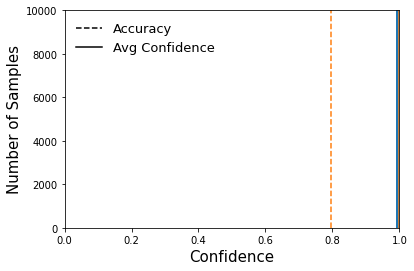

-0.20383597416281696

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,10000,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,10000,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)
plt.ylim(0,10000)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPBBP.pdf',format='pdf')
plt.show()

sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


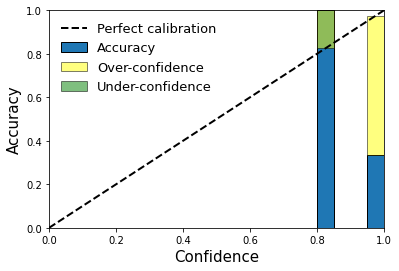

0.6416666666666668

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()

max(xaxis[store_local!=0]-store_local[store_local!=0])


In [ ]:
net = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))
net.load('/content/theta_best.dat')


Net:
 Creating Net!! 
    Total params: 4.79M
Reading /content/theta_best.dat

  restoring epoch: 14, lr: 0.250000


bayes_linear_2L(
  (bfc1): BayesLinear_Normalq()
  (bfc2): BayesLinear_Normalq()
  (bfc3): BayesLinear_Normalq()
  (act): ReLU(inplace=True)
)

In [ ]:
# set batch_size = 1 and find which index of the graph in the testloader is not predicted well by the current method 
# condition I err.cpu().detach().numpy()==1 : prediction is wrong 
# condition II np.max(probs.cpu().detach().numpy())<0.2 : unconfident prediction 
valloader_plot = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
import torchvision

for j, (x, y) in enumerate(valloader_plot):
    cost, err, probs = net.eval(x, y)
    if err.cpu().detach().numpy()==1 and np.max(probs.cpu().detach().numpy())<0.9:
      img=torchvision.utils.make_grid(x*0.3081+0.1307)
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.show()
      print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    if j>1000:
      break

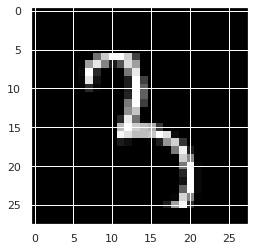

195 tensor([3]) tensor([5]) tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


<Figure size 432x288 with 0 Axes>

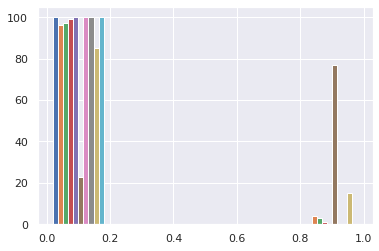

404 tensor([2]) tensor([2]) tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


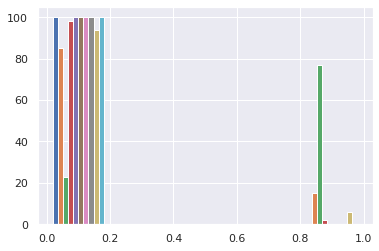

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==195:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)

#plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')
plt.savefig('dp_bbp_hist3.pdf',bbox_inches = 'tight')
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    #plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)

#plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')
plt.savefig('dp_bbp_hist2.pdf',bbox_inches = 'tight')

plt.show()


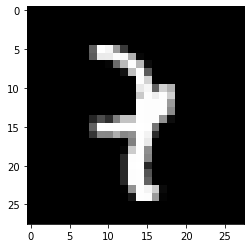

551 tensor([7]) tensor([1]) tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
True label is tensor([7])


<Figure size 432x288 with 0 Axes>

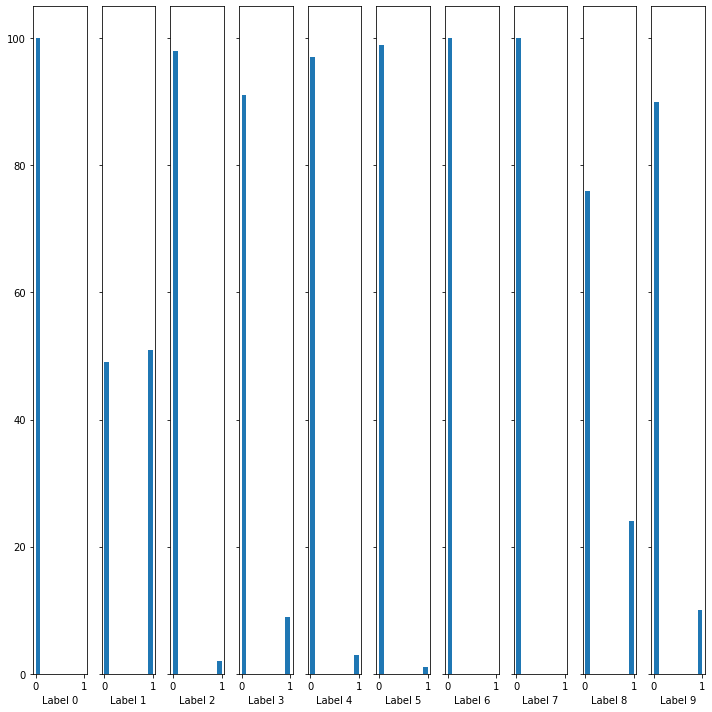

In [ ]:
hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==551:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('DP_BBP_dropout_hist7.png')

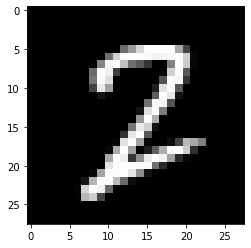

404 tensor([2]) tensor([2]) tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
True label is tensor([2])


<Figure size 432x288 with 0 Axes>

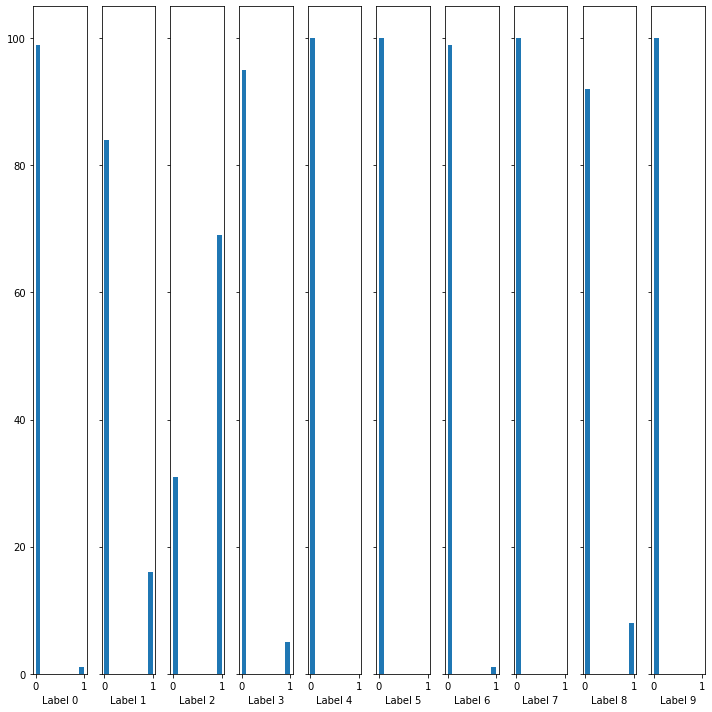

In [ ]:
hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break

prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])
  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


n_bins = 10

print("True label is", y)

fig, axs = plt.subplots(1, 10, sharey=True, tight_layout=True, figsize=(10,10))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(prob_list[0], bins=n_bins,range=[0, 1])
axs[0].set_xlabel('Label 0')
axs[1].hist(prob_list[1], bins=n_bins,range=[0, 1])
axs[1].set_xlabel('Label 1')
axs[2].hist(prob_list[2], bins=n_bins,range=[0, 1])
axs[2].set_xlabel('Label 2')
axs[3].hist(prob_list[3], bins=n_bins,range=[0, 1])
axs[3].set_xlabel('Label 3')
axs[4].hist(prob_list[4], bins=n_bins,range=[0, 1])
axs[4].set_xlabel('Label 4')
axs[5].hist(prob_list[5], bins=n_bins,range=[0, 1])
axs[5].set_xlabel('Label 5')
axs[6].hist(prob_list[6], bins=n_bins,range=[0, 1])
axs[6].set_xlabel('Label 6')
axs[7].hist(prob_list[7], bins=n_bins,range=[0, 1])
axs[7].set_xlabel('Label 7')
axs[8].hist(prob_list[8], bins=n_bins,range=[0, 1])
axs[8].set_xlabel('Label 8')
axs[9].hist(prob_list[9], bins=n_bins,range=[0, 1])
axs[9].set_xlabel('Label 9')

fig.savefig('DP_BBP_dropout_hist2.png')

<Figure size 600x400 with 0 Axes>

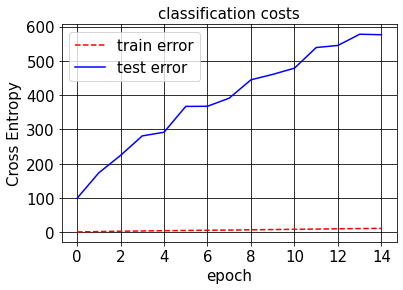

<Figure size 432x288 with 0 Axes>

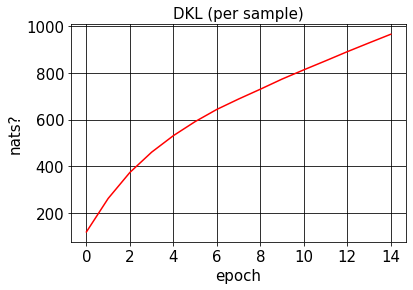

<Figure size 600x400 with 0 Axes>

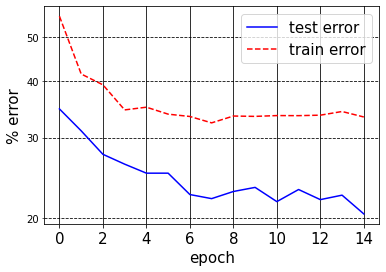

In [ ]:
## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['train error', 'test error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

In [ ]:




textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['train error', 'test error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

# DPBBP (Laplacian): define the Bayes linear 2l with laplacian prior 

In [ ]:
class bayes_linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(bayes_linear_2L, self).__init__()
        
        n_hid = 1200
        self.prior_instance = laplace_prior(mu=0, b=0.1)
#         prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
#        self.prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        
        tlqw = 0
        tlpw = 0
        
        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        return y, tlqw, tlpw
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)
        
        for i in range(Nsamples):
            
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw 
            
        return predictions, tlqw_vec, tlpw_vec

# DPBBP training MNIST (Laplacian)

In [ ]:
import copy

class Bayes_Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, Nbatches=0):
        super(Bayes_Net, self).__init__()
        print(' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0)


    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = x.to(device), y.long().to(device)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='none')
            Edkl = (tlqw - tlpw)/self.Nbatches
            
        elif samples > 1:
            mlpdw_cum = torch.zeros_like(y)
            Edkl_cum = 0
            
            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='none')
                Edkl_i = (tlqw - tlpw)/self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i 
            
            mlpdw = mlpdw_cum/samples
            Edkl = Edkl_cum/samples
  
        loss = Edkl+mlpdw

        #########################################################################################################
        clipped_grads = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

        for i in range(loss.size(0)):
            loss[i].backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.5)
            for name, param in self.model.named_parameters():
                clipped_grads[name] += param.grad / loss.size(0)
            self.model.zero_grad()

        for name, param in self.model.named_parameters():
            param.grad = clipped_grads[name]

        self.optimizer.step()
        with torch.no_grad():
            for param in self.model.parameters():
                param.add_(torch.randn_like(param) * 1.3/loss.size(0))
        #########################################################################################################

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, torch.mean(mlpdw.data), err

    def eval(self, x, y, train=False):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')
        print(out)
        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = x.to(device), y.long().to(device)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []
        
        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name+'.W_mu'].data
                    W_p = state_dict[layer_name+'.W_p'].data

    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)
    
    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu)/sig_W)
                b_snr = (torch.abs(b_mu)/sig_b)
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = W_snr > thresh
                    mask_dict[layer_name+'.b'] = b_snr > thresh
                    
                else:
                
                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)
        
        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)
    
    
    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                
                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)  
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)  
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w, do_sum=False) - self.model.prior_instance.loglike(W, do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b, do_sum=False) - self.model.prior_instance.loglike(b, do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = KL_W > thresh
                    mask_dict[layer_name+'.b'] = KL_b > thresh
                    
                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)
        
        if thresh is not None:
            return mask_dict
        else:    
            return np.array(weight_KLD_vec)

import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy

# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 100
nb_epochs = 15
log_interval = 1

savemodel_its = [20, 50, 80, 120]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
print('\nData:')


# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
print( '\nNetwork:')

lr = 0.25
nsamples = 3
########################################################################################
net = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))

epoch = 0






Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/15, Jtr_KL = 60.861721, Jtr_pred = 1.104809, err = 0.550967,    time: 460.253711 seconds

    Jdev = 104.775631, err = 0.344400

best test error
Writting ../theta_best.dat

it 1/15, Jtr_KL = 99.197808, Jtr_pred = 2.297945, err = 0.409183,    time: 462.092493 seconds

    Jdev = 189.130237, err = 0.308800

best test error
Writting ../theta_best.dat

it 2/15, Jtr_KL = 121.977992, Jtr_pred = 3.469063, err = 0.383317,    time: 460.115814 seconds

    Jdev = 249.620625, err = 0.271300

best test error
Writting ../theta_best.dat

it 3/15, Jtr_KL = 137.702500, Jtr_pred = 4.202075, err = 0.338700,    time: 460.483745 seconds

    Jdev = 324.521300, err = 0.261400

best test error
Writting ../theta_best.dat

it 4/15, Jtr_KL = 149.785250, Jtr_pred = 5.317230, err = 0.342667,    time: 464.215077 seconds

    Jdev = 349.286000, err = 0.246500

best test error
Writting ../theta_best.dat

it 5/15, Jtr

In [ ]:
## ---------------------------------------------------------------------------------------------------------------------
# train
print('\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=nsamples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    print('   time: %f seconds\n' % (toc - tic))

    # Save state dict
    
    if i in savemodel_its:
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        print('    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            print('best test error')
            net.save('../theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
print( '   average time: %f seconds\n' % runtime_per_it)

net.save('../theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
print( '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
#print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save('../cost_train.npy', kl_cost_train)
np.save('../cost_train.npy', pred_cost_train)
np.save('../cost_dev.npy', cost_dev)
np.save('../err_train.npy', err_train)
np.save('../err_dev.npy', err_dev)

# Visualization of the results

In [ ]:
## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig('../err.png',  bbox_extra_artists=(lgd,), box_inches='tight')